<center>
    <h1>
        <b>
            Finding the Sweet Spot: Towards a Framework for Optimal Configurations of Feature Attribution Based Explanations
        </b>
    </h1>
<h2>
    Arthur-Louis Heath <br>
</h2>
    <i>
        <b>
            Created for BSc Thesis: Computer Science and Mathematics (2021) <br>
            Department of Computing Science<br>
            University of Aberdeen
        </b>
    </i>
</center>

# INSTALL DEPENDENCIES & LOAD LIBRARIES

In [1]:
###### INSTALL DEPENDENCIES #######
!python -m pip install numpy
!python -m pip install pandas
!python -m pip install sklearn
!python -m pip install scipy
!python -m pip install lime
!python -m pip install shap
!python -m pip install dice-ml
!python -m pip install jinja2
!python -m pip install num2words

In [2]:
###### LOAD LIBRARIES #######

# Jupyter
from dataclasses import dataclass
from ipywidgets import interactive


# Data Processing

import numpy as np
import pandas as pd

from copy import deepcopy


# Model

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay as cmd

import scipy

from sklearn.preprocessing import LabelEncoder


# Explainability Tools

## LIME
import lime
import lime.lime_tabular

## SHAP
import shap

## Global Linear Approximation (Linear Regression)
from sklearn import linear_model

## DiCE
import dice_ml
from dice_ml.utils import helpers # helper functions


# Natural Language Generation
from jinja2 import Template, FileSystemLoader, Environment
from num2words import num2words


# Visualisation
import matplotlib

from matplotlib import pyplot as plt
from matplotlib import cm, rc, gridspec

# DATASET
## Analytics Vidhya Loan Approval Dataset
## Source: https://www.kaggle.com/leonbora/analytics-vidhya-loan-prediction

## Load Dataset

In [3]:
# Load Dataset
orig_dataset = pd.read_csv('loan_appproval_dataset.csv')
orig_dataset = orig_dataset.drop(columns=['Loan_ID'])
orig_dataset


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


### Data Cleaning

In [4]:
# Remove rows with missing values (EG LoanAmount = NaN)

orig_dataset = orig_dataset.dropna()

orig_dataset

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [5]:
# Prettify feature names for display

pretty_names = ['Gender', 
                'Marrital Status',
                'Num. Dependents',
                'Education', 
                'Employment Type', 
                'Applicant Income', 
                'Co-Applicant Income', 
                'Loan Amount', 
                'Loan Duration', 
                'Credit History Status', 
                'Property Area Type', 
                'Application Status']

orig_dataset.columns = pretty_names

target_feat_id = 'Application Status'

orig_dataset.columns

Index(['Gender', 'Marrital Status', 'Num. Dependents', 'Education',
       'Employment Type', 'Applicant Income', 'Co-Applicant Income',
       'Loan Amount', 'Loan Duration', 'Credit History Status',
       'Property Area Type', 'Application Status'],
      dtype='object')

In [6]:
# Prettify label names for categorical feature values

# 'Marrital Status'
print(orig_dataset['Employment Type'].unique())
orig_dataset.loc[:, ['Employment Type']] = orig_dataset['Employment Type'].apply(lambda x: 'Self-Employed' if x == 'Yes' else 'Not Self-Employed' if x == 'No' else x)
print(orig_dataset['Employment Type'].unique())
print()

# 'Marrital Status'
print(orig_dataset['Marrital Status'].unique())
orig_dataset.loc[:, ['Marrital Status']] = orig_dataset['Marrital Status'].apply(lambda x: 'Married' if x == 'Yes' else 'Unmarried' if x == 'No' else x)
print(orig_dataset['Marrital Status'].unique())
print()

# 'Application Status'
print(orig_dataset['Application Status'].unique())
orig_dataset.loc[:, ['Application Status']] = orig_dataset['Application Status'].apply(lambda x: 'Approved' if x == 'Y' else 'Rejected' if x == 'N' else x)
print(orig_dataset['Application Status'].unique())
print()

# 'Accesible Credit History'
print(orig_dataset['Credit History Status'].unique())
orig_dataset.loc[:, ['Credit History Status']] = orig_dataset['Credit History Status'].apply(lambda x: 'Available' if x == 1 else 'Unavailable' if x == 0 else x)
print(orig_dataset['Credit History Status'].unique())


['No' 'Yes']
['Not Self-Employed' 'Self-Employed']

['Yes' 'No']
['Married' 'Unmarried']

['N' 'Y']
['Rejected' 'Approved']

[1. 0.]
['Available' 'Unavailable']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Encode Categorical Data

In [7]:
# Multi column data encoder class

# Required since sklearns default encoder cannot decode on multiple columns
# Adapted from code courtesy of user gereleth on stack overflow
# (source: https://stackoverflow.com/questions/58217005/how-to-reverse-label-encoder-from-sklearn-for-multiple-columns)

class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns # array of column names to encode


    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output

In [8]:
# Encode categorical data

dataset = deepcopy(orig_dataset)

# List of categorical features to encode (as integers starting from 0)
label_encode = ['Gender', 
                'Marrital Status',
                'Num. Dependents',
                'Education', 
                'Employment Type',
                'Credit History Status', 
                'Property Area Type', 
                'Application Status']

le = MultiColumnLabelEncoder(columns=label_encode)

dataset = le.fit_transform(dataset)

dataset

,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type,Application Status
1,1,0,1,0,0,4583,1508.0,128.0,360.0,0,0,1
2,1,0,0,0,1,3000,0.0,66.0,360.0,0,2,0
3,1,0,0,1,0,2583,2358.0,120.0,360.0,0,2,0
4,1,1,0,0,0,6000,0.0,141.0,360.0,0,2,0
5,1,0,2,0,1,5417,4196.0,267.0,360.0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,1,0,0,0,2900,0.0,71.0,360.0,0,0,0
610,1,0,3,0,0,4106,0.0,40.0,180.0,0,0,0
611,1,0,1,0,0,8072,240.0,253.0,360.0,0,2,0
612,1,0,2,0,0,7583,0.0,187.0,360.0,0,2,0


In [9]:
# Create test/train split for Model Training

X = dataset.drop(columns=[target_feat_id]).values
y = dataset[target_feat_id]

test_size = 0.3
random_state = 0

# Parameter random_state=0 ensures the version of the model is identical to the one used in the project. Feel free to change this. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


# MODEL
## Create and train SKLearn random forrest classifier

In [10]:

untrained_model = sklearn.ensemble.RandomForestClassifier(n_estimators=1000)
model = untrained_model.fit(X_train, y_train.astype('int'))

# Display classifier metrics
y_pred = [lab for lab in model.predict(X_test)]

test_class = [np.int64(z) for z in y_test.values]

report = classification_report(test_class, y_pred)
print('\n' + report)
accuracy = accuracy_score(test_class, y_pred)
print('Accuracy: ' + str(accuracy))


              precision    recall  f1-score   support

           0       0.76      0.98      0.86        95
           1       0.91      0.41      0.56        49

    accuracy                           0.78       144
   macro avg       0.84      0.69      0.71       144
weighted avg       0.81      0.78      0.76       144

Accuracy: 0.7847222222222222


# DATA INSTANCE
## Select data instance and compute feature attributions of SHAP LIME and GAM libraries

In [11]:
# Select data instance
data_instance_index = 62
data_instance = np.array(dataset.loc[data_instance_index])[:-1]
data_instance_orig_labels = orig_dataset.loc[data_instance_index]

# print(X_test[13])
print(data_instance)
print(data_instance_orig_labels)

# Create df to hold attribution results for each method and composites
feature_names = dataset.drop(columns=[target_feat_id]).columns

attributions = pd.DataFrame(columns = feature_names)

[1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 2.609e+03 3.449e+03
 1.650e+02 1.800e+02 1.000e+00 0.000e+00]
Gender                            Male
Marrital Status                Married
Num. Dependents                      0
Education                 Not Graduate
Employment Type          Self-Employed
Applicant Income                  2609
Co-Applicant Income               3449
Loan Amount                        165
Loan Duration                      180
Credit History Status      Unavailable
Property Area Type               Rural
Application Status            Rejected
Name: 62, dtype: object


# Compute LIME attributions

In [12]:
# list of indices (ints) corresponding to the categorical columns. Everything else will be considered continuous
categorical_feature_indecies =  [0, 1, 2, 3, 4, 8, 9, 10]

In [13]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=list(feature_names), 
                                                   categorical_features=categorical_feature_indecies, 
                                                   verbose=True,
                                                   mode='classification')


In [14]:
exp = explainer.explain_instance(data_instance, model.predict_proba, num_features=len(feature_names))

Intercept 0.25277392290839035
Prediction_local [0.81178164]
Right: 0.714


In [15]:
# Convert back from lime representations to feature names
lime_attr = {}

# WARNING: Features who's names appear as substrings of names of other features break this code
for feat in exp.as_list():
    for f_name in list(feature_names):
        if(f_name in feat[0]):
            lime_attr[f_name] = feat[1]
            
lime_attr = pd.Series(lime_attr)
lime_attr

Credit History Status    0.508159
Loan Amount             -0.057968
Applicant Income        -0.013600
Co-Applicant Income      0.057203
Num. Dependents          0.052848
Marrital Status         -0.046500
Property Area Type       0.039513
Education                0.022788
Employment Type          0.018699
Gender                  -0.012670
Loan Duration           -0.009465
dtype: float64

In [16]:
# record lime attributions
lime_attr.name = 'LIME'

attributions = attributions.append(lime_attr)

attributions

,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type
LIME,-0.01267,-0.0465,0.052848,0.022788,0.018699,-0.0136,0.057203,-0.057968,-0.009465,0.508159,0.039513


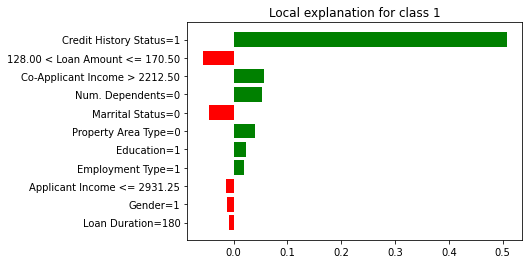

In [17]:
# Visualise lime attributions
# %matplotlib inline
fig = exp.as_pyplot_figure()

# Compute SHAP attributions

In [18]:


pd.DataFrame(np.array([data_instance]), columns=feature_names)

,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type
0,1.0,0.0,0.0,1.0,1.0,2609.0,3449.0,165.0,180.0,1.0,0.0


In [19]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(
    pd.DataFrame(np.array([data_instance]), 
                 columns=feature_names))

# Select appropriate set of shap values based on model prediction
shap_values = shap_values[model.predict([data_instance])[0]]

shap_values
            
#shap_values
# 
# shap.plots.force(shap_values)
# dict(pd.Series(shap_values, index=feature_names))
# dictionary = dict(zip(shap_values, feature_names))
# 
# shap.plots.bar({A: B for A, B in zip(feature_names, shap_values)})
# shap.plots.bar(dict(pd.Series(list(shap_values[0]), index=feature_names)))

array([[-0.00628974, -0.00457027,  0.01026815,  0.01046501,  0.01904679,
        -0.02578044,  0.00625192,  0.00522768, -0.02579822,  0.44338667,
        -0.01354981]])

In [20]:
# record shap attributions

# list(shap_values[0])

shap_attr = pd.Series(list(shap_values[0]), index=feature_names)


shap_attr.name = 'SHAP'

#shap_attr
attributions = attributions.append(shap_attr)

type(attributions.index)

attributions

,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type
LIME,-0.01267,-0.04650,0.052848,0.022788,0.018699,-0.01360,0.057203,-0.057968,-0.009465,0.508159,0.039513
SHAP,-0.00629,-0.00457,0.010268,0.010465,0.019047,-0.02578,0.006252,0.005228,-0.025798,0.443387,-0.013550


# Train general linear model for alternative global attribution estimator
### (this is disabled by default but can be enabled as needed)

In [21]:
# Run linear regression

regr = linear_model.LinearRegression()

# Since we are explaining model, run regression on model predictions

# Warning, note that here we are using variable encodings as dummy variables, depending on feature semantics this may not be optimal

X_all = dataset.drop(columns=[target_feat_id]).to_numpy()

Y_all = model.predict(X_all)

regr.fit(X_all, Y_all)

print(regr.coef_)


[ 1.05278520e-02  8.64706866e-02 -3.03667063e-02  1.92420499e-03
  4.48558840e-02 -1.45857401e-06  1.10325919e-05  2.95938515e-04
  2.62333255e-04  7.55998451e-01  3.30911558e-03]


In [22]:
regr_attr = pd.Series(list(regr.coef_), index=feature_names)

regr_attr.name = 'GLOBAL REGRESSION'

# attributions = attributions.append(regr_attr)

attributions

,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type
LIME,-0.01267,-0.04650,0.052848,0.022788,0.018699,-0.01360,0.057203,-0.057968,-0.009465,0.508159,0.039513
SHAP,-0.00629,-0.00457,0.010268,0.010465,0.019047,-0.02578,0.006252,0.005228,-0.025798,0.443387,-0.013550


# GENERATE COUNTERFACTUAL/S
## Using Dice-ML (Based on https://arxiv.org/abs/1905.07697)

In [23]:
# Features that can vary in counterfactual examples
# 'Marrital Status', 'Num. Dependents'?

features_to_vary = ['Education', 
                    'Employment Type', 
                    'Applicant Income', 
                    'Co-Applicant Income',  
                    'Loan Duration',
                    'Credit History Status', 
                    'Property Area Type']

In [24]:
# Wrap objects for use with dice
dice_data = dice_ml.Data(dataframe=dataset,
                 continuous_features=[x for x in dataset.columns if x not in label_encode],
                 outcome_name=target_feat_id)

dice_model = dice_ml.Model(model=model, backend="sklearn")

# KD-Tree finds counterfactuals within the dataset
# This is good since we are working with a rather innacurate model and small dataset
# resulting in randomly sampled counterfactuals being erratic

# dice_exp = dice_ml.Dice(dice_data, dice_model, method='kdtree')

dice_exp = dice_ml.Dice(dice_data, dice_model)
dice_instance = pd.DataFrame([data_instance], columns=feature_names)

# Generate counterfactuals
counterfactual = dice_exp.generate_counterfactuals(dice_instance, 
                                                   total_CFs=1, 
                                                   desired_class="opposite",
                                                   features_to_vary=features_to_vary)

# features_to_vary= //// Features to vary
# feature_weights=feature_weights /// Dict of feature weithgts

counterfactual.visualize_as_dataframe(show_only_changes=True)

# Through minor surgery we can obtain counterfactuals as a dataframe
counterfactual = counterfactual.cf_examples_list[0].final_cfs_df

counterfactual


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

Query instance (original outcome : 1)


,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type,Application Status
0,1.0,0.0,0.0,1.0,1.0,2609.0,3449.0,165.0,180.0,1.0,0.0,1



Diverse Counterfactual set (new outcome: 0.0)


,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type,Application Status
0,-,-,-,-,-,1397.0,-,-,-,0.0,-,0.0


,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type,Application Status
0,1.0,0.0,0.0,1.0,1.0,1397.0,3449.0,165.0,180.0,0.0,0.0,0


In [25]:
# Save/Load counterfactuals for reproducability

# This line can be uncommented to save newly generated counterfactuals
# counterfactual.to_csv('survey/counter_fact/counterfactuals_save.csv')

# By default, this file contains counterfactual examples used in the study
counterfactual = pd.read_csv('survey/counter_fact/counterfactuals_load.csv')

counterfactual = counterfactual.reset_index(drop=True)

counterfactual

,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type,Application Status
0,1.0,0.0,0.0,1.0,1.0,2609.0,3449.0,165.0,404.3,0.0,0.0,0
1,1.0,0.0,0.0,1.0,1.0,2609.0,3449.0,165.0,180.0,0.0,2.0,0
2,1.0,0.0,0.0,1.0,1.0,2609.0,5785.4,165.0,180.0,0.0,0.0,0


In [26]:
# Decode feature encodings for newly generated counterfactual example

# Fix column dtypes
counterfactual[label_encode] = counterfactual[label_encode].astype(int)

decoded_counterfactuals = le.inverse_transform(counterfactual)
# decoded_counterfactuals = le.inverse_transform(orig_)

decoded_counterfactuals

,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type,Application Status
0,Male,Married,0,Not Graduate,Self-Employed,2609.0,3449.0,165.0,404.3,Available,Rural,Approved
1,Male,Married,0,Not Graduate,Self-Employed,2609.0,3449.0,165.0,180.0,Available,Urban,Approved
2,Male,Married,0,Not Graduate,Self-Employed,2609.0,5785.4,165.0,180.0,Available,Rural,Approved


# Estimate attributions using DiCE

In [27]:
# Compute dice attributions from set of counterfactuals
imp = dice_exp.local_feature_importance(dice_instance, total_CFs=50)

print(imp.local_importance[0])

100%|██████████| 1/1 [00:09<00:00,  9.34s/it]

{'Credit History Status': 1.0, 'Applicant Income': 0.26, 'Loan Duration': 0.24, 'Loan Amount': 0.22, 'Co-Applicant Income': 0.2, 'Property Area Type': 0.12, 'Num. Dependents': 0.08, 'Education': 0.08, 'Gender': 0.06, 'Marrital Status': 0.04, 'Employment Type': 0.04}


In [28]:
# Add dice attributions

dice_attr = pd.Series(imp.local_importance[0].values(), index=feature_names)

dice_attr.name = 'DICE-ML'

#shap_attr
attributions = attributions.append(dice_attr)

attributions

,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type
LIME,-0.01267,-0.04650,0.052848,0.022788,0.018699,-0.01360,0.057203,-0.057968,-0.009465,0.508159,0.039513
SHAP,-0.00629,-0.00457,0.010268,0.010465,0.019047,-0.02578,0.006252,0.005228,-0.025798,0.443387,-0.013550
DICE-ML,1.00000,0.26000,0.240000,0.220000,0.200000,0.12000,0.080000,0.080000,0.060000,0.040000,0.040000


# NORMALISE ATTRIBUTIONS


In [29]:
# Express attributions as percentage of the sum of the absolute value of each attribution
# This is done so that they can be presented on a common axis.

for index, row in attributions.iterrows():
    scale = row.abs().sum()
    row.update(row.apply(lambda x : x * 100 / scale))

attributions

,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type
LIME,-1.509353,-5.539600,6.295825,2.714726,2.227621,-1.620189,6.814663,-6.905745,-1.127547,60.537468,4.707263
SHAP,-1.102236,-0.800909,1.799425,1.833925,3.337826,-4.517854,1.095609,0.916116,-4.520969,77.700616,-2.374516
DICE-ML,42.735043,11.111111,10.256410,9.401709,8.547009,5.128205,3.418803,3.418803,2.564103,1.709402,1.709402


# CALCULATE COMPOSITE SCORES

In [30]:
composite_scores = {}
for col in attributions:
    composite_scores[col] = np.mean(attributions[col])

composite_scores = pd.Series(composite_scores)
composite_scores.name = 'COMPOSITE'

#shap_attr
attributions = attributions.append(composite_scores)

attributions 

,Gender,Marrital Status,Num. Dependents,Education,Employment Type,Applicant Income,Co-Applicant Income,Loan Amount,Loan Duration,Credit History Status,Property Area Type
LIME,-1.509353,-5.539600,6.295825,2.714726,2.227621,-1.620189,6.814663,-6.905745,-1.127547,60.537468,4.707263
SHAP,-1.102236,-0.800909,1.799425,1.833925,3.337826,-4.517854,1.095609,0.916116,-4.520969,77.700616,-2.374516
DICE-ML,42.735043,11.111111,10.256410,9.401709,8.547009,5.128205,3.418803,3.418803,2.564103,1.709402,1.709402
COMPOSITE,13.374485,1.590201,6.117220,4.650120,4.704152,-0.336613,3.776358,-0.856942,-1.028138,46.649162,1.347383


# PREPARE TEXT TEMPLATES

In [31]:
# Prepare Jinja2 templates for NLG

APP_OUT = "loan_approval_outcome.txt"
BASE_EXP = "base_textual_explanation.txt"
COUNTER = "textual_counterfactual.txt"


In [32]:
templateLoader = FileSystemLoader(searchpath="./templates")
templateEnv = Environment(loader=templateLoader)

# Load templates
temp_app_outcome = templateEnv.get_template(APP_OUT)
temp_base_exp = templateEnv.get_template(BASE_EXP)
temp_counterfact = templateEnv.get_template(COUNTER)

temp_app_outcome.render(acceptance='Hello World!')

'\nBased on the decision of our automated loan approval system, your loan has been \\textbf{\\textcolor{red}{ Hello World!. }}'

# CONSTRUCT EXPLANATION

In [33]:
# Display settings

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 35}

rc('font', **font)
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')

In [34]:
# Structure to store data needed to generate explanation unrelated to explanation settings/layers

@dataclass
class PublicData:
    # Pandas dataframe of counterfactual explanations
    counterfactuals : pd.DataFrame
    
    # Pandas dataframe of feature attributions
    attributions : pd.DataFrame
        
    # Feature values of explanation instance
    feature_values : pd.Series

In [35]:
# Initialise explanation data

pub_data = PublicData(
    counterfactuals=decoded_counterfactuals,
    attributions=attributions,
    feature_values = data_instance_orig_labels)


In [36]:
# Helper function for cleaning data before display

def add_units(features):
    features = deepcopy(features)
    # Add units to select features and remove decimal places
    # features <-- pandas series of feature values
    features['Applicant Income'] = str(int(features['Applicant Income'])) + ' \$/Mo'
    features['Co-Applicant Income'] = str(int(features['Co-Applicant Income'])) + ' \$/Mo'
    features['Loan Amount'] = str(int(features['Loan Amount'])) + '000 \$'
    features['Loan Duration'] = str(int(features['Loan Duration'])) + ' Months'
    
    return features

print(add_units(pub_data.feature_values))

Gender                            Male
Marrital Status                Married
Num. Dependents                      0
Education                 Not Graduate
Employment Type          Self-Employed
Applicant Income            2609 \$/Mo
Co-Applicant Income         3449 \$/Mo
Loan Amount                  165000 \$
Loan Duration               180 Months
Credit History Status      Unavailable
Property Area Type               Rural
Application Status            Rejected
Name: 62, dtype: object


In [37]:
def construct_explanation(pub_data, visualise=False, num_feats=2, display_min=False, display_composite=True, display_counterfactuals=False):
    '''
    Method to generate arbitrary explanation from configuration space.
    
    The parameters are as follows:
    visualise <-- Weather to display explanations as text or visualise as plots
    attributions <-- pandas dataframe containing normalised attributions of each model and composite attribution scores
    num_feats <-- number of features to display (display the num_feats top positive contributors according to composite scores).
                  if Set to 0, all featueres are displayed
    display_min <-- If true, display num_feats least (highest negatively) contributing features aswell
    display_composite <-- if true, display composite scores instead of individual models' attributions
    '''
    
    if visualise:
        plt.rcParams['figure.constrained_layout.use'] = True
    
    # Easier to run notebook cells asyncronously
    pub_data = deepcopy(pub_data)
    attributions = pub_data.attributions
    
    # Preprocess feature names
    for ind, row in pub_data.counterfactuals.iterrows():
        pub_data.counterfactuals.loc[ind] = add_units(pub_data.counterfactuals.loc[ind])
    
    pub_data.feature_values = add_units(pub_data.feature_values)
    
    if num_feats == 0:
        num_feats = len(attributions.columns)
    # Construct plot
    
    # Number of grid cells for table of counterfactuals to take up
    cellspertable = int(len(attributions.columns) / 2)
    
    # Number of grid cells for plot of single counterfactual to take up
    cellsperplot = 1
    
    # One for each feature/counterfactual and one for text
    if visualise:
        numfigs = num_feats * cellsperplot + 2
    else: 
        numfigs = ((num_feats+1)//2)
    
    if display_counterfactuals:
        numfigs += (cellspertable * len(pub_data.counterfactuals.index) + 1)
    
    # plt.rcParams['figure.figsize'] = [20, 3 * numfigs]
    
    fig = plt.figure(figsize=(21, 3 * numfigs))
    gs = gridspec.GridSpec(nrows=numfigs, ncols=2,
                        hspace=1, figure=fig)

    # fig.tight_layout()
    
    # Track y displacement in grid
    curr_figure = 0

    
    ###################### Textual explanation of classifier attributions ######################
    if not visualise:
        class_text_box = fig.add_subplot(gs[curr_figure:curr_figure + max((num_feats // 5), 1), :])
        curr_figure += max(((num_feats) // 5), 1)

        ordered_feats = list(reversed(pub_data.attributions.loc["COMPOSITE"].sort_values().index))

        text = temp_app_outcome.render(acceptance=pub_data.feature_values['Application Status'])
        text += temp_base_exp.render(num_feats=num_feats, 
                                    feature_vals=pub_data.feature_values,
                                   feats_by_contrib=ordered_feats,
                                    attributions=attributions.loc['COMPOSITE'],
                                    ordinals=[num2words(i, to="ordinal_num") for i in range(num_feats + 1)])

        class_text_box.text(-0.1, 1, text, wrap=True, linespacing=0.5)
        class_text_box.axis("off")
    
    ###################### Feature attribution plots ######################
    
    if visualise:
        class_text_box = fig.add_subplot(gs[curr_figure, :])
        curr_figure += 1
    
        text = temp_app_outcome.render(acceptance=pub_data.feature_values['Application Status'])

        class_text_box.text(-0.1, 1, text, wrap=True)
        class_text_box.axis("off")
    
        fp_text_box = fig.add_subplot(gs[curr_figure, :])
        curr_figure += 1

        # text explaining plots
        if num_feats == len(attributions.columns):
                text = """The following are the scores attributed to your application's features listed in order of importance:"""
        else:
            if display_min:
                text = "The following are the scores attributed to the " + str(num_feats) + """ features 
                of your application that contributed most/least to the classifier's decision: """
            else:
                if num_feats == 1:
                    text = "The following is the score attributed to the most imoportant feature of your application:"
                else:
                    text = "The following are the scores attributed to the " + str(num_feats) + """ most imoportant features of your application:"""

        fp_text_box.text(-0.1, 0.5, text, wrap=True)
        fp_text_box.axis("off")


        # Deide on common axis
        x_max = max([abs(max(attributions.max(axis=1))), 
                     abs(min(attributions.min(axis=1)))])

        xlim=(-1.1 *x_max, 1.1 * x_max)

        for i in range(num_feats):
            # find i-th most/least salient feature (by composite)
            feat_max = attributions.loc['COMPOSITE'].idxmax(axis=0)
            feat_min = attributions.loc['COMPOSITE'].idxmin(axis=0)

            if(display_composite):
                y_lab = ['SCORE']
                max_w = (attributions.loc['COMPOSITE'])[feat_max]
                min_w = (attributions.loc['COMPOSITE'])[feat_min]
            else:
                y_lab = list((pub_data.attributions.drop(['COMPOSITE'], axis=0)).index)
                max_w = [(attributions.loc[attr])[feat_max] for attr in y_lab]
                min_w = [(attributions.loc[attr])[feat_min] for attr in y_lab]

            # Plot i-th most/least salient feature

            colors_max = cm.autumn( [(1.0 / (i+1)) for i in range(len(y_lab))])
            colors_min = cm.winter( [(1.0 / (i+1)) for i in range(len(y_lab))])

            if display_min:
                axs1 = fig.add_subplot(gs[curr_figure : curr_figure + cellsperplot, 1])
                axs1.barh(y_lab, min_w, align='center', height=0.3, color=['#FFC20A' if val > 0 else '#0C7BDC' for val in max_w])
                axs1.set_xlim(xlim)
                axs1.set_xlabel('\% Of Total Feature Importance')
                axs1.set_title('Contribution of ' + feat_min + ' = ' + str(pub_data.feature_values[feat_min]))
                axs1.axvline(x=0, linewidth=1, color='k')

                axs2 = fig.add_subplot(gs[curr_figure : curr_figure + cellsperplot, 0])
                axs2.barh(y_lab, max_w, align='center', height=0.3, color=['#FFC20A' if val > 0 else '#0C7BDC' for val in min_w])
                axs2.set_xlim(xlim)
                axs1.xlabel('\% Of Total Feature Importance')
                axs2.set_title('Contribution of ' + feat_max + ' = ' + str(pub_data.feature_values[feat_max]))
                axs2.axvline(x=0, linewidth=1, color='k')

                # Remove features already displayed
                attributions = attributions.drop(feat_max, axis=1)
                attributions = attributions.drop(feat_min, axis=1)
            else:
                if type(max_w) != list:
                    max_w = [max_w]
                axs = fig.add_subplot(gs[curr_figure : curr_figure + cellsperplot, :])
                axs.barh(y_lab, max_w, color=['#FFC20A' if val > 0 else '#0C7BDC' for val in max_w])
                axs.set_xlim(xlim)
                axs.set_title('Contributions of ' + feat_max + ' = ' + str(pub_data.feature_values[feat_max]))
                axs.axvline(x=0, linewidth=1, color='k')
                axs.set_xlabel('\% Of Total Feature Importance')
                
                # Set bar labels
                ind = 0
                for i in axs.patches:
                    # get_width pulls left or right; get_y pushes up or down
                    axs.text(i.get_width()+.3, -1 * i.get_y(), \
                            str(round(max_w[ind], 2))+'%',
                            color='black')
                    
                    ind += 1
    
                
            attributions = attributions.drop(feat_max, axis=1)
            curr_figure += cellsperplot

    plt.rcParams['figure.constrained_layout.use'] = False
    
    if display_counterfactuals:
        # Display counterfactual explanations
        
        # Add counterfactual text
        text_box = fig.add_subplot(gs[curr_figure, :])
        curr_figure += 1
        
        text = "The following candidate profile/s similar to yours would have achieved the opposite outcome:"
        text_box.text(-0.1, 0.5, text, wrap=True)
        text_box.axis("off")
        
        cf_tables = []
        for index, row in pub_data.counterfactuals.iterrows():
            # Add table for each counterfactual explanation
            cf_tables.append(fig.add_subplot(gs[curr_figure :  curr_figure + cellspertable, :]))
            
            curr_figure += cellspertable
            
            cell_colours = [["#ffd1dc"] 
                            if row[attribute] != pub_data.feature_values[attribute] 
                            else ["#ffffff"]
                            for attribute in row.index]

            # cell_text = [[row[attribute]] for attribute in row.index]
            cell_text = [[ '\\textbf{' + str(pub_data.feature_values[attribute]) + '$\longrightarrow$ ' + str(row[attribute]) + '}']
                          if row[attribute] != pub_data.feature_values[attribute] 
                          else ['\\textbf{' + str(row[attribute]) + '}'] 
                          for attribute in row.index]
            
            tab = cf_tables[index].table(cellText=cell_text,
                                        rowLabels=['\\textbf{' + s + '}' for s in row.index],
                                        colLabels=['\\textbf{Value}'],
                                        loc="upper center",
                                        colWidths=[0.3],
                                        cellColours=cell_colours)
            
            tab.scale(1, 5)
            tab.set_fontsize(40)
            cf_tables[index].axis("off")
            pass
    return fig

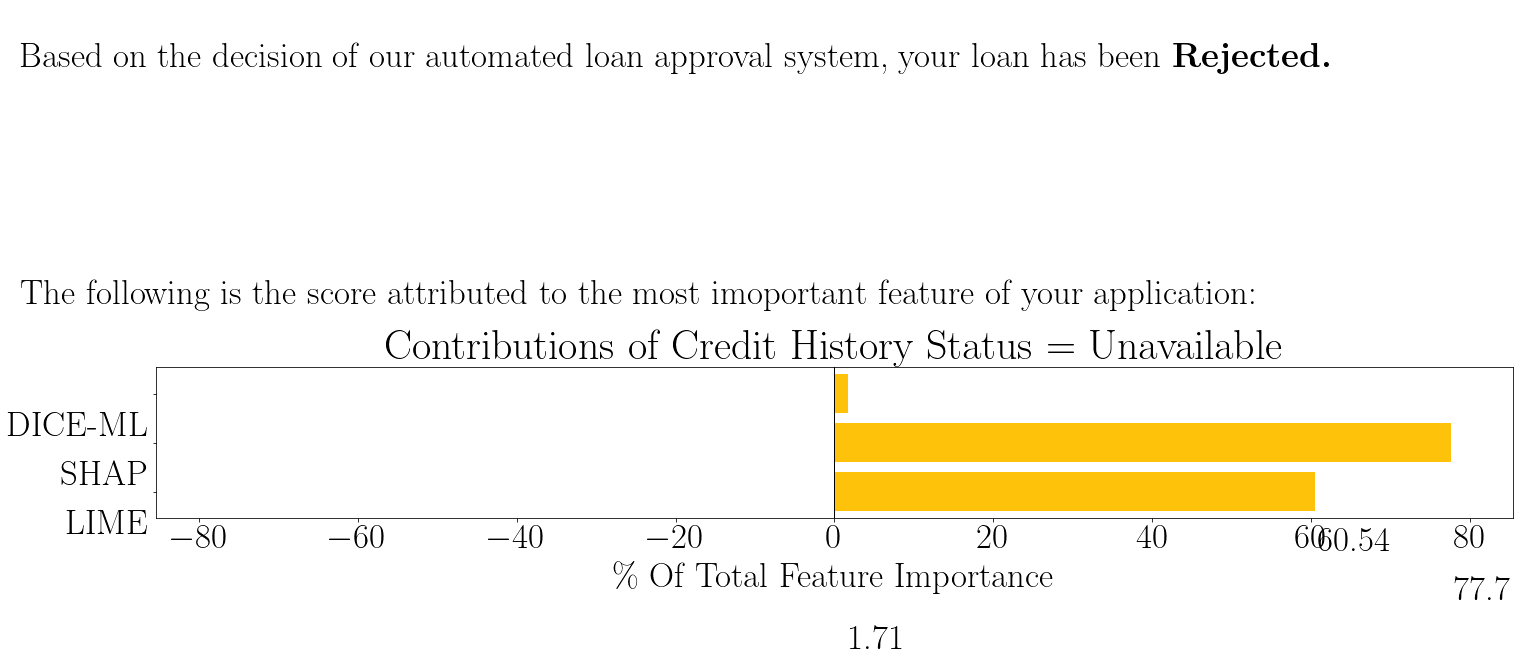

In [38]:
example_fig = construct_explanation(pub_data,
                      visualise=True,
                      num_feats=1,
                      display_composite=False,
                      display_min=False,
                      display_counterfactuals=False)


# plt.savefig('explanation.png', bbox_inches='tight')

In [39]:
# Render explanations to be used with experiments 

# This code can be uncommented for easy regeneration of plots
'''
text_few = construct_explanation(pub_data,
                      visualise=False,
                      num_feats=3,
                      display_composite=True,
                      display_min=False,
                      display_counterfactuals=False)
text_few.savefig('survey/text_few/explanation.png', bbox_inches='tight', dpi=200)

chart_few = construct_explanation(pub_data,
                      visualise=True,
                      num_feats=3,
                      display_composite=True,
                      display_min=False,
                      display_counterfactuals=False)
chart_few.savefig('survey/chart_few/explanation.png', bbox_inches='tight', dpi=200)


chart_many = construct_explanation(pub_data,
                      visualise=True,
                      num_feats=0,
                      display_composite=True,
                      display_min=False,
                      display_counterfactuals=False)

chart_many.savefig('survey/chart_many/explanation.png', bbox_inches='tight', dpi=200)


chart_models = construct_explanation(pub_data,
                      visualise=True,
                      num_feats=3,
                      display_composite=False,
                      display_min=False,
                      display_counterfactuals=False)
chart_models.savefig('survey/chart_few_models/explanation.png', bbox_inches='tight', dpi=200)



chart_count = construct_explanation(pub_data,
                      visualise=True,
                      num_feats=3,
                      display_composite=True,
                      display_min=False,
                      display_counterfactuals=True)
chart_count.savefig('survey/chart_few_count/explanation.svg', bbox_inches='tight', dpi=200)
'''
# Feature Quantity explanations


# CHART SINGLE
'''

example_fig = construct_explanation(pub_data,
                      visualise=True,
                      num_feats=1,
                      display_composite=True,
                      display_min=False,
                      display_counterfactuals=False)


plt.savefig('single_charts.png', bbox_inches='tight')
'''

'''

# CHART FEW

example_fig = construct_explanation(pub_data,
                      visualise=True,
                      num_feats=3,
                      display_composite=True,
                      display_min=False,
                      display_counterfactuals=False)


plt.savefig('three_charts.png', bbox_inches='tight')
'''

# CHART ALL

'''

example_fig = construct_explanation(pub_data,
                      visualise=True,
                      num_feats=0,
                      display_composite=True,
                      display_min=False,
                      display_counterfactuals=False)

plt.savefig('eleven_charts.png', bbox_inches='tight', dpi=200)
'''


"\n\nexample_fig = construct_explanation(pub_data,\n                      visualise=True,\n                      num_feats=0,\n                      display_composite=True,\n                      display_min=False,\n                      display_counterfactuals=False)\n\nplt.savefig('eleven_charts.png', bbox_inches='tight', dpi=200)\n"

(0.0, 1.0, 0.0, 1.0)

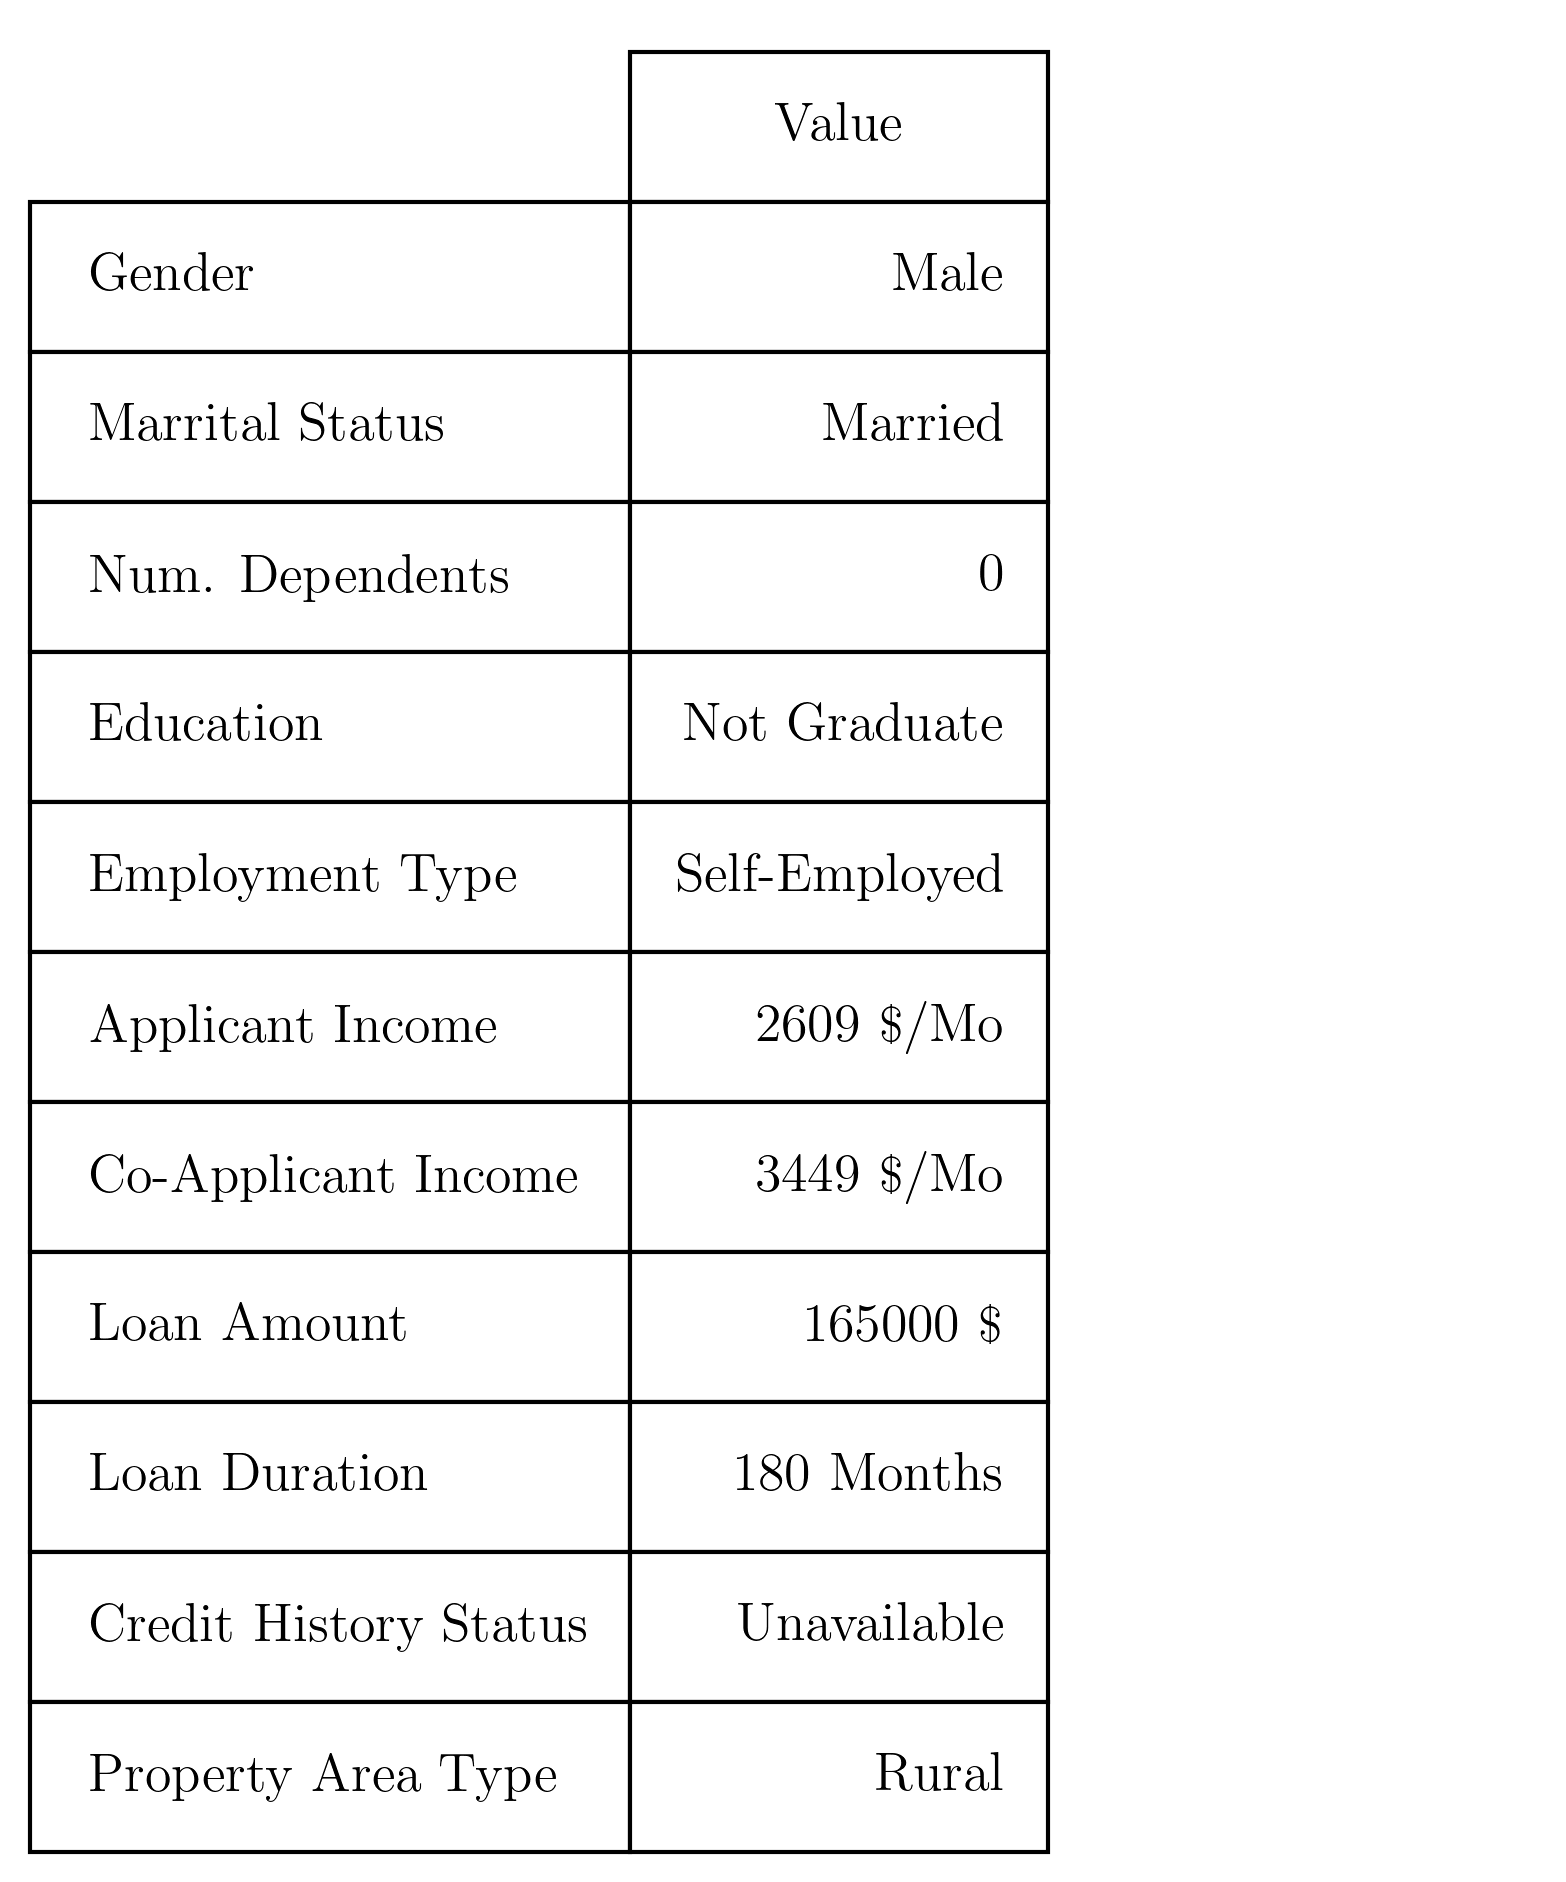

In [40]:
# Display table of feature values

fig = plt.figure(figsize=(6, 5), dpi=300)

cell_text = [[str(add_units(pub_data.feature_values)[attribute])] 
             for attribute in pub_data.feature_values.index]
    
f_value_table = plt.table(cellText=cell_text[:-1],
          rowLabels=pub_data.feature_values.index[:-1],
          colLabels=['Value'],
          loc="upper center",
          colWidths=[0.3])

f_value_table.scale(1, 3)
f_value_table.fontsize = 16

plt.axis('off')

# plt.savefig('survey/data_instance/feature_values.svg', bbox_inches='tight')

# INTERACTIVE DISPLAY TOOL

## An interactive widget that can be used to explore datapoints in the explanation space

In [41]:


def f(display_model_scores, display_all_features, display_counterfactuals, textual_attributions):
    if display_all_features:
        nf = 0
    else:
        nf = 3
    fig = construct_explanation(pub_data,
                      num_feats=nf,
                      visualise=not textual_attributions,
                      display_composite=not display_model_scores,
                      display_min=False,
                      display_counterfactuals= display_counterfactuals)
    # fig.show()

interactive_plot = interactive(f, display_model_scores=False, display_all_features=False, display_counterfactuals=False, textual_attributions=False)
output = interactive_plot.children[-1]
#output.layout.height = '2000px'

interactive_plot

interactive(children=(Checkbox(value=False, description='display_model_scores'), Checkbox(value=False, descrip…